## Import Modules and Load Functions

In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras import Sequential
from keras.src.callbacks import History
from keras.src.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error, r2_score

In [62]:
def get_df(data_size:int=100, path:str="..\Data\AAPL_stock_prices.csv", delimeter: str = ',', from_end: bool = True, date_column: str = 'Date', target_column: str = 'Close') -> tuple[np.ndarray, MinMaxScaler, pd.DataFrame]:
    df = pd.read_csv(path, delimiter=',')
    df = df.iloc[-data_size:, :] if from_end else df.iloc[:data_size, :]
    dates = pd.to_datetime(df[date_column])
    df.drop(columns=[date_column], inplace=True)
    df.index = dates

    scaler = MinMaxScaler(feature_range=(0, 1))
    merged_data = np.hstack((df[target_column].values.reshape(-1, 1), df.drop(columns=[target_column]).values))
    return scaler.fit_transform(merged_data), scaler, df

def create_dataset(data: np.ndarray, time_step: int=10, output_window_size: int = 1) -> tuple[np.ndarray, np.ndarray]:
    X, Y = [], []
    #(len, window_size, features)
    for i in range(len(data) - time_step):
        # Define the range of input sequences
        input_end_index = i + time_step
        
        # Define the range of output sequences
        output_end_index = input_end_index + output_window_size
        
        # Ensure that the dataset is within bounds
        if output_end_index > len(data)-1:
            break
            
        # Extract input and output parts of the pattern
        seq_x, seq_y = data[i:input_end_index], data[output_end_index]
        
        # Append the parts
        X.append(seq_x)
        Y.append(seq_y)

    return np.array(X), np.array(Y)  

def split_data(X: np.ndarray, Y: np.ndarray, train_size: float = 0.7, random_state: int = 42) -> tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    # X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)    
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = train_size, random_state = random_state)
    return X_train, X_test, Y_train, Y_test

def create_model(input_shape: tuple, layers_with_units: list[int] = [128,128,64], optimizer: str = 'adam', loss: str = 'mean_squared_error', metrics: list[str]=['accuracy']) -> Sequential:
    # Create the LSTM model
    model = Sequential()
    for layer in layers_with_units[:-1]:
        model.add(LSTM(layer, return_sequences=True, input_shape=input_shape))
    model.add(LSTM(layers_with_units[-1], return_sequences=False))
    model.add(Dense(1))
    model.compile(optimizer = optimizer, loss = loss, metrics=metrics)
    return model

def show_loss(history: History):
    plt.figure(figsize=(10, 4))
    plt.plot(history.history['loss'], label='Loss')
    plt.plot(history.history['val_loss'], label='Value Loss')
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()
    
def predict(X_train, X_test, model: Sequential) -> tuple[np.ndarray, np.ndarray]:
    return model.predict(X_train), model.predict(X_test)

# Inverse transform the predictions
def update_data_to_inverse(predicted_data: np.ndarray, scaler: MinMaxScaler, target_column_index: int = 0, feature_number: int = 6):
    new_dataset = np.zeros(shape=(len(predicted_data), feature_number))
    new_dataset[:,target_column_index] = predicted_data.flatten()
    return scaler.inverse_transform(new_dataset)[:, target_column_index].reshape(-1, 1)

def calculate_scores(Y_train: np.ndarray, Y_test: np.ndarray, train_predict: np.ndarray, test_predict: np.ndarray, target_column_index: int = 0, print_results : bool = True) -> dict:
    # Calculate MSE
    train_mse = mean_squared_error(Y_train[:, target_column_index].reshape(-1, 1), train_predict)
    test_mse = mean_squared_error(Y_test[:, target_column_index].reshape(-1, 1), test_predict)

    # Calculate R2 score
    train_r2 = r2_score(Y_train[:, target_column_index].reshape(-1, 1), train_predict)
    test_r2 = r2_score(Y_test[:, target_column_index].reshape(-1, 1), test_predict)

    if print_results:
        print(f"Train MSE: {train_mse:.4f}, Test MSE: {test_mse:.4f}")
        print(f"Train R2 Score: {train_r2:.4f}, Test R2 Score: {test_r2:.4f}")
    return {"mse": {"test": test_mse, "train": train_mse}, "r2": {"test": test_r2, "train": train_r2}}

def draw_graph(scaler: MinMaxScaler, time_step: int, target_column_index: int, train_predict: np.ndarray, test_predict: np.ndarray, scaled_data: np.ndarray):
    print(f"{time_step=}, {X.shape=}, {(len(train_predict) + time_step)=}")
    print(f"{test_predict.shape=}, {train_predict.shape=}, {scaled_data.shape=}")

    # Plot the predictions
    plt.figure(figsize=(15, 6))
    plt.plot(scaler.inverse_transform(scaled_data)[:, target_column_index], label='Original Data')
    train_predict_plot = np.empty_like(scaled_data[:, target_column_index]).reshape(-1, 1)
    train_predict_plot[:, :] = np.nan
    train_predict_plot[time_step:len(train_predict) + time_step, :] = train_predict
    plt.plot(train_predict_plot, label='Training Predictions')

    test_predict_plot = np.empty_like(scaled_data[:, target_column_index]).reshape(-1, 1)
    test_predict_plot[:, :] = np.nan
    test_predict_plot[len(train_predict) + time_step:len(scaled_data[:, target_column_index]) - 1, :] = test_predict
    plt.plot(test_predict_plot, label='Testing Predictions')

    plt.title('Time Series Prediction')
    plt.legend()
    plt.show()    
    


## Code

In [63]:
data, scaler, *_ = get_df(data_size=1000)
X: np.ndarray
Y: np.ndarray
X, Y = create_dataset(data=data)
X_train, X_test, Y_train, Y_test = split_data(X, Y)
print(f"{X_train.shape=}\n{X_test.shape=}\n{Y_train.shape=}\n{Y_test.shape=}")

X_train.shape=(692, 10, 6)
X_test.shape=(297, 10, 6)
Y_train.shape=(692, 6)
Y_test.shape=(297, 6)


In [64]:
# Create the LSTM model
model = Sequential()
model.add(LSTM(256, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

c:\Users\orhun\.conda\envs\stockprice\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [65]:
model = create_model(input_shape=(X_train.shape[1], X_train.shape[2]))

In [66]:
history = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=1, batch_size=1, verbose=1)

692/692 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 1.6794e-05 - loss: 0.0453 - val_accuracy: 5.6117e-04 - val_loss: 0.0432


In [67]:
train_predict, test_predict = predict(X_train, X_test, model)
print(f"{train_predict.shape=}, {test_predict.shape=}, {Y_train.shape=}, {Y_test.shape=}")

22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
train_predict.shape=(692, 1), test_predict.shape=(297, 1), Y_train.shape=(692, 6), Y_test.shape=(297, 6)


In [68]:
print(train_predict[:1])
print(test_predict[:1])
print(Y_train[:1, :])
print(Y_test[:1, :])

[[0.36190665]]
[[0.37557158]]
[[0.36733976 0.37990103 0.37314493 0.36831939 0.37092474 0.18574775]]
[[0.38047791 0.41738771 0.39814495 0.38254797 0.37232555 0.32406545]]


In [69]:
train_predict = update_data_to_inverse(train_predict, scaler=scaler, feature_number=Y_train.shape[1])
test_predict = update_data_to_inverse(test_predict, scaler=scaler, feature_number=Y_train.shape[1])
Y_train = scaler.inverse_transform(Y_train)
Y_test = scaler.inverse_transform(Y_test)

print(f"{train_predict.shape=}, {test_predict.shape=}, {Y_train.shape=}, {Y_test.shape=}")

train_predict.shape=(692, 1), test_predict.shape=(297, 1), Y_train.shape=(692, 6), Y_test.shape=(297, 6)


In [70]:
print(train_predict[:1])
print(test_predict[:1])
print(Y_train[:1, :])
print(Y_test[:1, :])

[[125.74383119]]
[[127.29357107]]
[[1.26360001e+02 1.26889999e+02 1.28660004e+02 1.25080002e+02
  1.25327507e+02 8.91136000e+07]]
[[1.27849998e+02 1.31190002e+02 1.31490005e+02 1.26699997e+02
  1.25488419e+02 1.37564700e+08]]


In [71]:
calculate_scores(Y_train = Y_train , Y_test = Y_test , train_predict = train_predict , test_predict = test_predict)

Train MSE: 257.3810, Test MSE: 267.5510
Train R2 Score: 0.5745, Test R2 Score: 0.5651


{'mse': {'test': 267.5509828934602, 'train': 257.38102052313474},
 'r2': {'test': 0.5651311679562215, 'train': 0.5745079287993657}}

time_step=10, X.shape=(989, 10, 6), (len(train_predict) + time_step)=702
test_predict.shape=(297, 1), train_predict.shape=(692, 1), scaled_data.shape=(1000, 6)


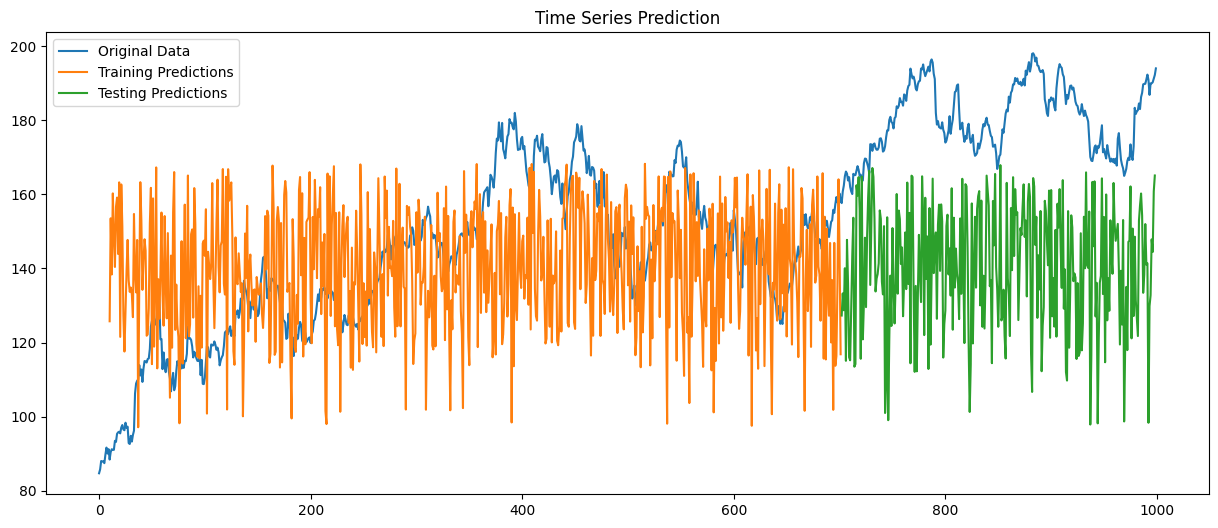

In [72]:
draw_graph(scaler, 10, 0, train_predict, test_predict, scaled_data=data)